<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/GraphAndTextBasedRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taken from: [YANN CLAUDEL](https://www.kaggle.com/code/yclaudel/recommendation-engine-with-networkx/notebook)  for practice purpose.

In [ ]:
# Clone the repository first using the following command
!npx degit https://github.com/mequanent/HCC-2022 -f

npx: installed 1 in 1.975s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/HCC-2022#HEAD


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [ ]:
df1 = pd.read_csv('netflix_titles.csv')
df1.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...


In [ ]:
# load the data
df = pd.read_csv('netflix_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]


In [ ]:
print(df.shape)

(6234, 19)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)
tfidf

<6234x16151 sparse matrix of type '<class 'numpy.float64'>'
	with 85759 stored elements in Compressed Sparse Row format>

In [ ]:
print(len(text_content))

6234


In [ ]:
# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
print('kmeans before', kmeans)
kmeans.fit(tfidf)
print('kmeans after', kmeans)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
print('centers ', centers)
terms = vector.get_feature_names_out()
print('terms', terms)
print('No of terms', len(terms))
print('size of centers', centers.shape)

kmeans before MiniBatchKMeans(n_clusters=200)
kmeans after MiniBatchKMeans(n_clusters=200)
centers  [[10407 12796 11529 ... 10757 10756     0]
 [ 8713  7310  1242 ... 10759 10758     0]
 [ 8548  5254  8358 ... 10358 10357  8075]
 ...
 [ 1907 15414  3040 ... 10758 10757     0]
 [11747  7251 13944 ... 10755 10754     0]
 [10677  2197  1776 ... 10758 10757     0]]
terms ['000' '007' '009' ... 'łukasz' 'ōarai' 'şeref']
No of terms 16151
size of centers (200, 16151)


In [ ]:
request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head() 

156    5377
2       306
159     200
80       97
132      65
Name: cluster, dtype: int64

In [ ]:
print(len(df['cluster']))
print(df['cluster'].value_counts().sum())
df['cluster'].value_counts()

6234
6234


156    5377
2       306
159     200
80       97
132      65
       ... 
189       1
23        1
79        1
5         1
188       1
Name: cluster, Length: 193, dtype: int64

In [ ]:
print(request_transform.shape)
print(request_transform)
request_transform[0, 1000]

(6234, 16151)
  (0, 15666)	0.2549894999462199
  (0, 13751)	0.28637035582363746
  (0, 10849)	0.30574130391758125
  (0, 10772)	0.3349599621004589
  (0, 7994)	0.250024519412352
  (0, 6249)	0.2992432957760891
  (0, 5029)	0.2159450924007513
  (0, 1437)	0.28864948455920847
  (0, 1215)	0.3520517814588317
  (0, 987)	0.3426454744948529
  (0, 896)	0.3520517814588317
  (1, 12863)	0.21766524210185317
  (1, 12816)	0.3538634305855354
  (1, 12330)	0.3267451084008534
  (1, 12139)	0.2701366185232751
  (1, 11866)	0.3380002290250218
  (1, 11480)	0.2777326753224245
  (1, 7966)	0.21532881847829755
  (1, 7639)	0.3538634305855354
  (1, 2932)	0.1852100149268106
  (1, 2463)	0.2256501604351425
  (1, 1135)	0.2725084640314895
  (1, 1027)	0.3538634305855354
  (2, 11225)	0.26277455125059385
  (2, 10072)	0.37000470636739613
  :	:
  (6232, 15419)	0.24506799432840556
  (6232, 12841)	0.2359455002861169
  (6232, 12393)	0.29967138705439883
  (6232, 12081)	0.3231532800573765
  (6232, 9236)	0.38391242714500157
  (6232, 904

0.0

In [ ]:
print(centers.shape)
print(centers.max())
print(centers)
print(terms[16150])
print(terms[centers[0,0]])
terms

(200, 16151)
16150
[[10407 12796 11529 ... 10757 10756     0]
 [ 8713  7310  1242 ... 10759 10758     0]
 [ 8548  5254  8358 ... 10358 10357  8075]
 ...
 [ 1907 15414  3040 ... 10758 10757     0]
 [11747  7251 13944 ... 10755 10754     0]
 [10677  2197  1776 ... 10758 10757     0]]
şeref
paroled


array(['000', '007', '009', ..., 'łukasz', 'ōarai', 'şeref'], dtype=object)

In [ ]:
#print the centers of the clusters
for i in range(0, k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:10]:
        word_list.append(terms[j])
    print(word_list)


cluster0:
['paroled', 'sentence', 'ranking', 'math', 'redemption', 'financial', 'executive', 'teacher', 'prison', 'romance']
cluster1:
['make', 'infertile', 'bachelors', 'condition', 'diagnosed', 'choose', 'runs', 'baby', 'career', 'time']
cluster2:
['love', 'falls', 'life', 'young', 'woman', 'friends', 'fall', 'triangle', 'true', 'man']
cluster3:
['dress', 'makeup', 'commercial', 'support', 'talent', 'desperate', 'uses', 'single', 'try', 'son']
cluster4:
['frustrating', 'renewal', 'visa', 'simply', 'software', 'engineer', 'process', 'decide', 'return', 'navigate']
cluster5:
['retiree', 'rediscovers', 'takeshi', 'desires', 'touch', 'eating', 'truly', 'recent', 'inner', 'warrior']
cluster6:
['relax', 'expecting', 'backwoods', 'cabin', 'psychotic', 'nightmare', 'killers', 'vacation', 'accused', 'boys']
cluster7:
['administrator', 'unenviable', 'interaction', 'witnessing', 'situation', 'troubling', 'teacher', 'student', 'finds', 'new']
cluster8:
['lucid', 'devastated', 'abducted', 'search

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 

request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()    

34     4148
35      608
69      451
5       209
141     190
Name: cluster, dtype: int64

In [ ]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [ ]:
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
        print('categories: ', rowi['categories'])    
        indices = find_similar(tfidf, i, top_n = 5)
        print('indices: ', indices)
        print("Sim("+rowi['title']+")")
        print("Sim("+rowi['title'][:15].strip()+")")

 iter 0 -- 336.6253488063812 seconds --
categories:  ['Children & Family Movies', 'Comedies']
indices:  [1780, 2222, 70, 6205, 4665]
Sim(Norm of the North: King Sized Adventure)
Sim(Norm of the Nor)
 iter 1000 -- 336.6740388870239 seconds --
categories:  ['Comedies', 'International Movies', 'Romantic Movies']
indices:  [4416, 744, 3961, 2268, 5462]
Sim(All's Well, End's Well (2009))
Sim(All's Well, End)
 iter 2000 -- 336.7222788333893 seconds --
categories:  ['Stand-Up Comedy']
indices:  [1271, 3285, 1673, 5384, 904]
Sim(Bridget Christie: Stand Up for Her)
Sim(Bridget Christi)
 iter 3000 -- 336.76692032814026 seconds --
categories:  ['Stand-Up Comedy']
indices:  [3453, 3193, 3983, 3775, 1668]
Sim(Tom Segura: Completely Normal)
Sim(Tom Segura: Com)
 iter 4000 -- 336.81280183792114 seconds --
categories:  ['Anime Series', 'International TV Shows']
indices:  [5171, 5576, 449, 954, 4667]
Sim(Cyborg 009: Call of Justice)
Sim(Cyborg 009: Cal)
 iter 5000 -- 336.8631317615509 seconds --
catego

In [ ]:
df['title'].loc[5969]

'Baby Ballroom'

In [ ]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time)) 

 iter 0 -- 0.026570796966552734 seconds --
 iter 1000 -- 3.6228232383728027 seconds --
 iter 2000 -- 7.235874176025391 seconds --
 iter 3000 -- 10.796688795089722 seconds --
 iter 4000 -- 14.348527669906616 seconds --
 iter 5000 -- 17.96995973587036 seconds --
 iter 6000 -- 21.666112184524536 seconds --
 finish -- 22.547775983810425 seconds --


In [ ]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()              

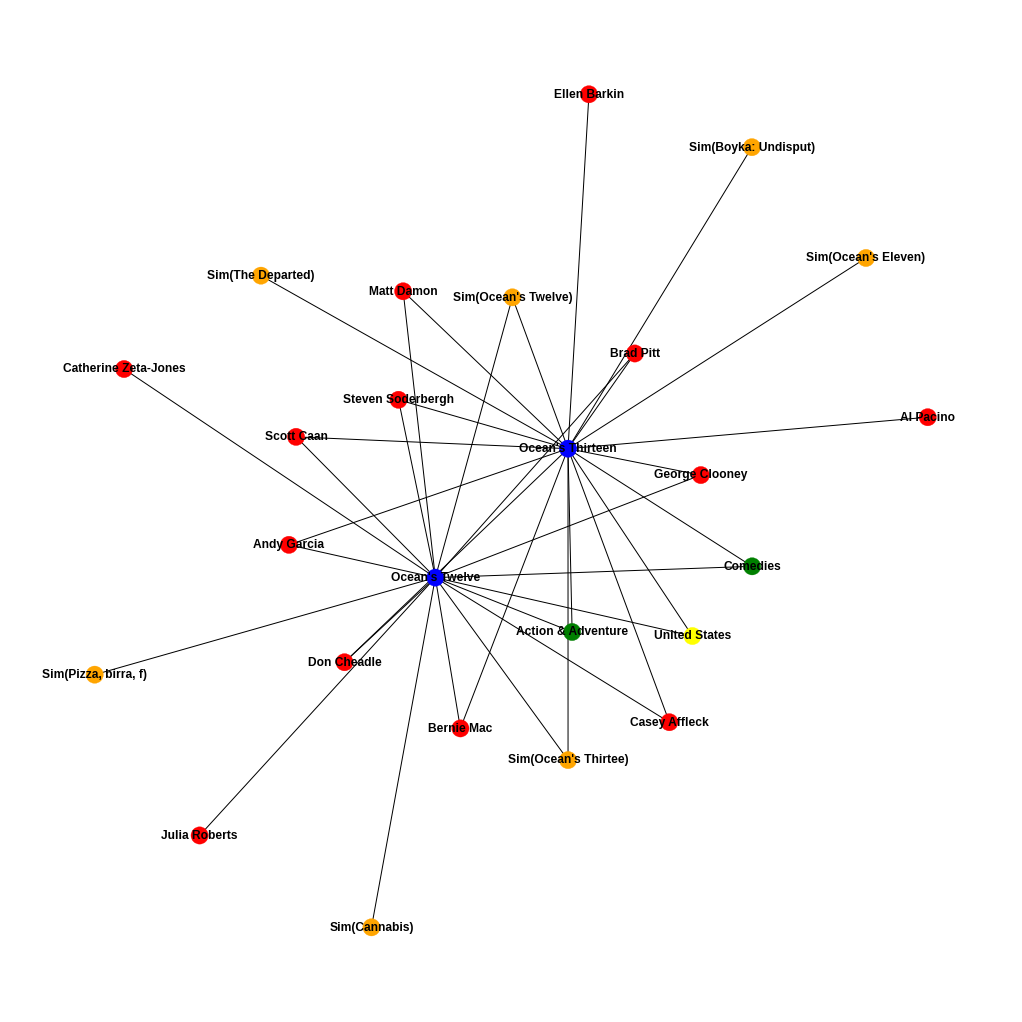

In [ ]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [ ]:
print(G.neighbors("Ocean's Thirteen"))
print(G.nodes["Ocean's Thirteen"]) # Attributes of the given node
G.nodes["Ocean's Thirteen"]['label']

{'key': 70058024, 'label': 'MOVIE', 'mtype': 'Movie', 'rating': 'PG-13'}


'MOVIE'

In [ ]:
    commons_dict = {}
    for e in G.neighbors("Ocean's Twelve"):
        #print('e before: ', commons_dict.get(e))
        for e2 in G.neighbors(e):
            if e2=="Ocean's Twelve":
                continue
            if G.nodes[e2]['label']=="MOVIE":
                #print('e2: ', commons_dict.get(e2))
                commons = commons_dict.get(e2)
                if commons==None:
                    #print('dict e2 before: ', commons_dict.get(e2))
                    #print('e2 : ', e)
                    commons_dict.update({e2 : [e]})
                    #print('e2: ', commons_dict.get(e2))
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
        #print('e after: ', commons_dict.get(e))
print(len(commons_dict))
commons_dict                   

3526


{"Ocean's Thirteen": ["Sim(Ocean's Thirtee)",
  'George Clooney',
  'Brad Pitt',
  'Matt Damon',
  'Andy Garcia',
  'Don Cheadle',
  'Bernie Mac',
  'Casey Affleck',
  'Scott Caan',
  'Action & Adventure',
  'Comedies',
  'Steven Soderbergh',
  'United States',
  "Sim(Ocean's Twelve)"],
 "Ocean's Eleven": ["Sim(Ocean's Thirtee)",
  'Action & Adventure',
  'Comedies',
  'United States',
  "Sim(Ocean's Twelve)"],
 'The Departed': ["Sim(Ocean's Thirtee)", 'Matt Damon', 'United States'],
 'Boyka: Undisputed': ["Sim(Ocean's Thirtee)",
  'Action & Adventure',
  'United States'],
 "The Eagle of El-Se'eed": ["Sim(Ocean's Thirtee)"],
 'Norman Lear: Just Another Version of You': ['George Clooney',
  'United States'],
 'The Men Who Stare at Goats': ['George Clooney', 'Comedies', 'United States'],
 'Good Night, and Good Luck': ['George Clooney', 'United States'],
 'The Peacemaker': ['George Clooney', 'Action & Adventure', 'United States'],
 'Up in the Air': ['George Clooney', 'Comedies', 'United S

In [ ]:
i = 0
for key, values in commons_dict.items():
  if i % 1000 == 0:
    print(key)
    print(values)
  i = i + 1

Ocean's Thirteen
["Sim(Ocean's Thirtee)", 'George Clooney', 'Brad Pitt', 'Matt Damon', 'Andy Garcia', 'Don Cheadle', 'Bernie Mac', 'Casey Affleck', 'Scott Caan', 'Action & Adventure', 'Comedies', 'Steven Soderbergh', 'United States', "Sim(Ocean's Twelve)"]
Irada Pakka
['Comedies']
Cam
['United States']
Maria Bamford: The Special Special Special
['United States']


In [ ]:
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    result

Ocean's Thirteen       7.575565
Ocean's Eleven         1.542593
The Informant!         1.346214
Babel                  1.199195
The Mask of Zorro      1.194038
                         ...   
Howards End            0.127186
Coraline               0.127186
Wild Wild Country      0.127186
Take Your Pills        0.127186
Shine On with Reese    0.127186
Length: 3526, dtype: float64

In [ ]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e)) # Closeness measurement based on Adamic Adar
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;                          

In [ ]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Autopsy of Jane Doe                  1.032475
The Diabolical                           1.032475
dtype: float64
****************************************
 Recommenda

In [ ]:
print(result.index[:4])
print(result.index[:4].values)
res = list(result.index[:4].values)
res.extend(["Ocean's Twelve"])
res

Index(['Ocean's Thirteen', 'Ocean's Eleven', 'The Informant!', 'Babel'], dtype='object')
["Ocean's Thirteen" "Ocean's Eleven" 'The Informant!' 'Babel']


["Ocean's Thirteen",
 "Ocean's Eleven",
 'The Informant!',
 'Babel',
 "Ocean's Twelve"]

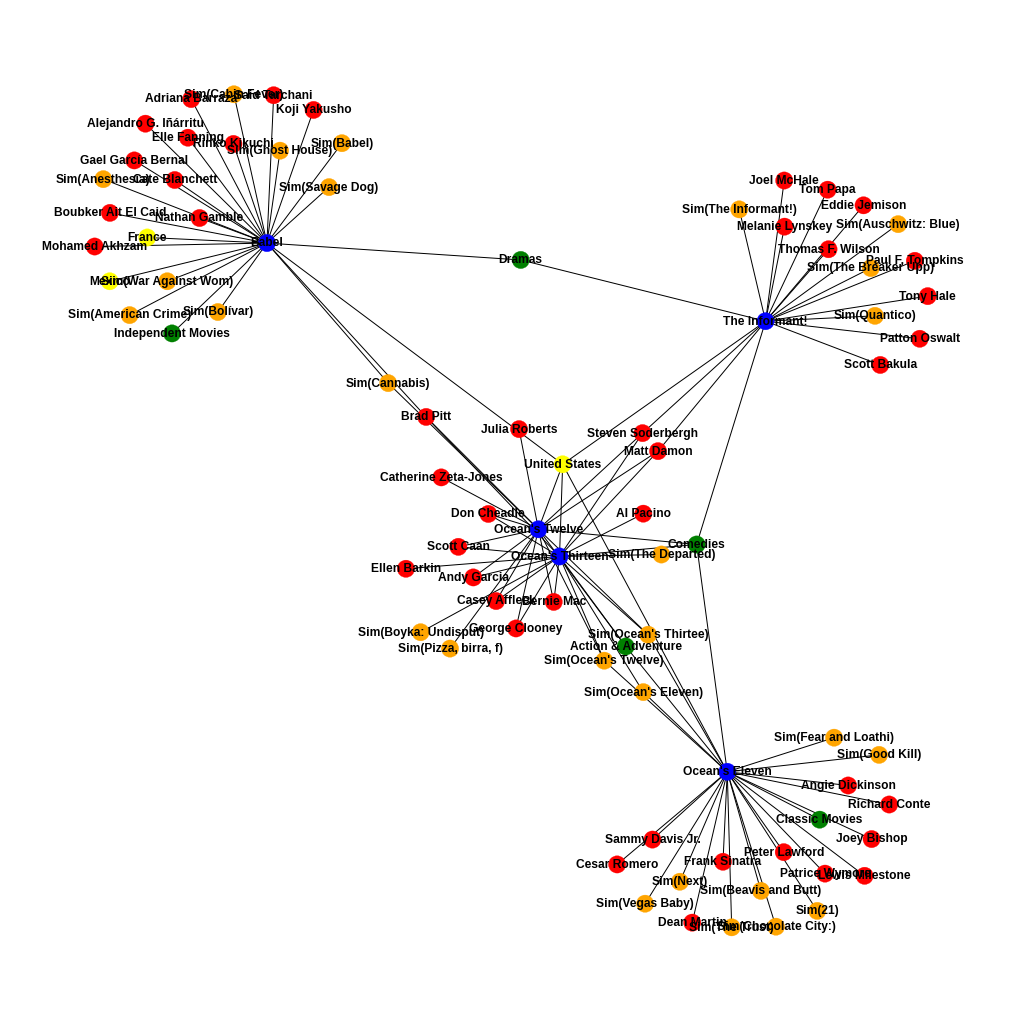

In [ ]:
# Draw top recommendations, to see the common nodes
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

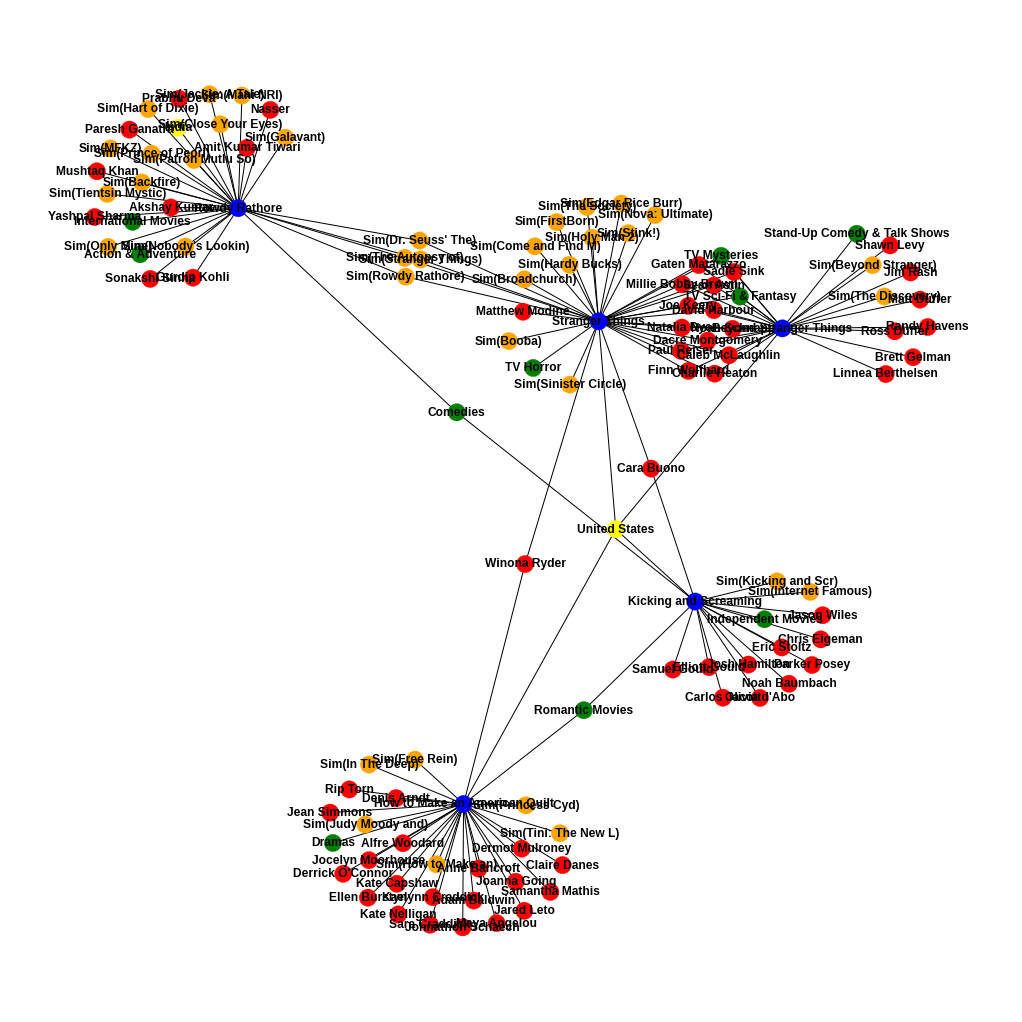

In [ ]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)